In [2]:
using Plots
using Random
rng = MersenneTwister(1234);

Let's simulate the Ornstein-Uhlenbeck (OU) process: 
$$
X_t = -\alpha X_t dt + \sqrt{2D} dW_t, \qquad X_0 = x_0
$$

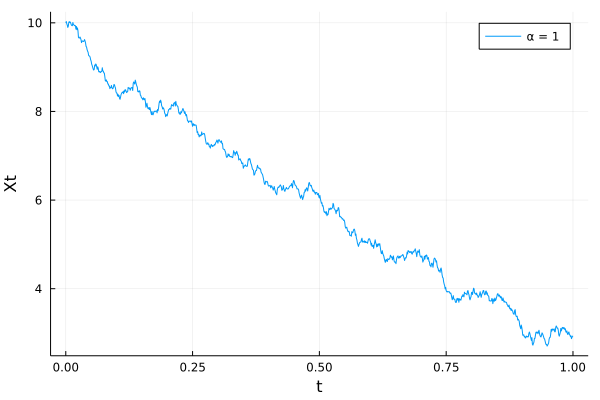

In [3]:
## Set the parameters
α = 1; # drift
D = 1; # diffusion
x0 = 10.0; # initial condition
K = 1000; # number of time steps
Tf = 1; # final time

# First, let's do a simple integration:
Δt = Tf/K; # time-step
X = zeros(K+1); # vector to store the trajectory
X[1] = x0; # initialise
for i = 2:K+1
    X[i] = X[i-1] + -α * X[i-1] * Δt + sqrt(2*D*Δt)*randn(rng) # Euler-Maruyama discretisation
end
plot(0:Δt:K*Δt, X,
    xlabel="t",
    ylabel="Xt",
    label = "α = $α"
    )

In [4]:
# Build a function to do the same
function integrate_OU(;Tf=1.0, K=1000, D=1, α = 1.0, x0 = 5.0)
    Δt = Tf/K; # time-step
    X = zeros(K+1); # vector to store the trajectory
    xi = randn(rng,K); # normally distributed increments
    X[1] = x0; # initial condition
    for i = 2:K+1
        X[i] = X[i-1] + -α * X[i-1]*Δt + sqrt(2*D*Δt)*xi[i-1]; # Euler-Maruyama discretisation
    end
    
    plot!(0:Δt:K*Δt, X,
    xlabel="t",
    ylabel="Xt",
    label = "α = $α, D = $D"
    )
end

integrate_OU (generic function with 1 method)

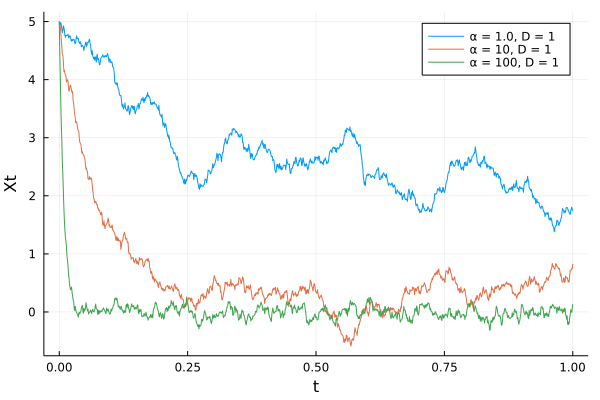

In [5]:
# See what happens as we vary the drift strength
plot()
integrate_OU()
integrate_OU(α = 10)
integrate_OU(α = 100)

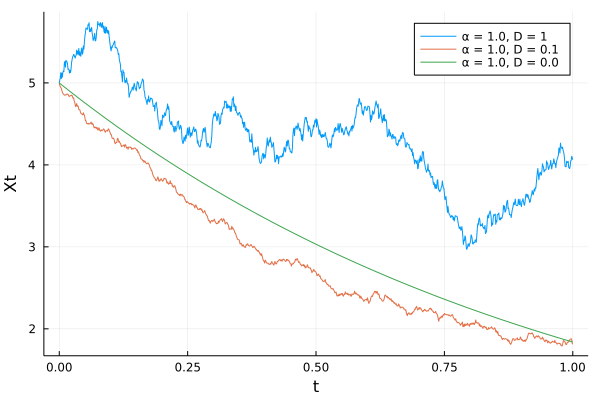

In [6]:
# Of course, this is equivalent to reducing the diffusion coefficient (up to time rescaling)
plot()
integrate_OU()
integrate_OU(D = 0.1)
integrate_OU(D = 0.0)

In fact, the paths of the OU process can be sampled \emph{exactly} (see 10.1103/PhysRevE.98.012136). Noting that
$$
X_t \sim \mathcal N(x_0 e^{-\alpha t}, \sigma^2(t)), \qquad X_0 = x_0,
$$
then for times $t_n = n \Delta t$
$$
X_{n+1} = e^{-\alpha \Delta t} X_n + \sqrt{\sigma(t)} \xi_n, \qquad \xi_n \sim \mathcal N(0,1).
$$

In [7]:
# Write a function for the exact sampling
function exact_OU(;Tf=1.0, K=1000, D=1, α = 1.0, x0 = 5.0)
    Δt = Tf/K; # time-step
    X = zeros(K+1); # vector to store the trajectory
    xi = randn(rng,K); # normally distributed increments
    X[1] = x0; # initial condition
    var = D/α * (1 - exp(-2*α*Δt)); # variance
    for i = 2:K+1
        X[i] = exp(-α*Δt) * X[i-1] + sqrt(var)*xi[i-1];
    end
    plot!(0:Δt:K*Δt, X,
    xlabel="t",
    ylabel="Xt",
    label = "α = $α, D = $D, exact path"
    )
end

exact_OU (generic function with 1 method)

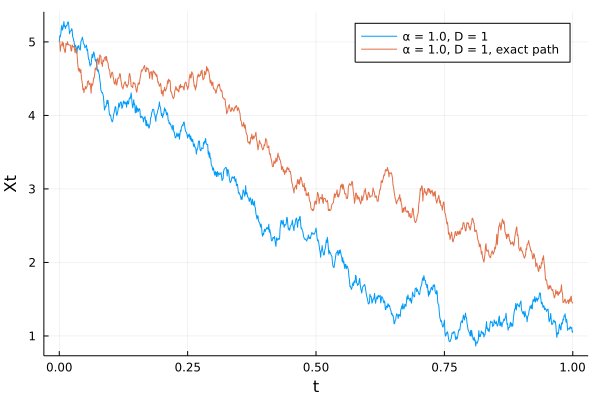

In [8]:
# Compare the approximated and exact paths
plot()
integrate_OU()
exact_OU()

# Note that to do a proper comparison we should have used the same random increments vector xi
# (more on this in following lectures)

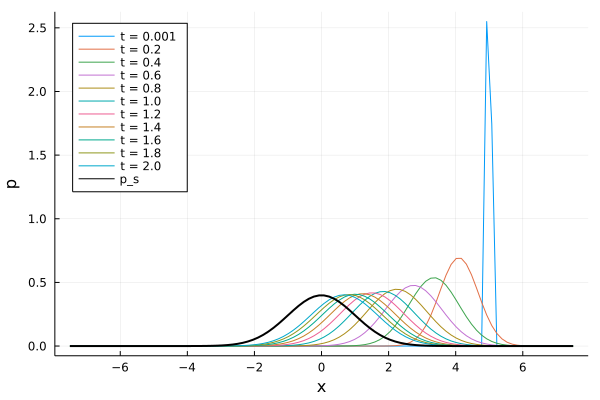

In [9]:
# We can also compare it to the explicit solution to the Fokker-Planck equation associated to the OU process

α = 1; # drift
D = 1; # diffusion
x0 = 5.0; # initial condition
Tf = 2.0; # final time
K = 10; # number of time points

mu(t) = x0 * exp.(-α*t); 
var(t) = D/α .* (1 .- exp.(-2 * α * t));
p(x,t) = 1 ./ sqrt.(2*pi*var(t)) .* exp.(- (1/2) * (x .- mu(t)).^2 ./var(t));

x = range(-1.5*x0, stop=1.5*x0, length=100);
plt = plot()
T = [1e-3; Tf/K:Tf/K:Tf];
for t ∈ T
    plot!(plt, 
        x, 1/sqrt(2*pi*var(t)) .* exp.(- (1/2) * (x .- mu(t)).^2/var(t)),
        xlabel="x",
        ylabel="p",
        label = "t = $t",
        legend=:topleft
    )
end

p_s(x) = sqrt(α/(2*pi*D)) * exp.(-α * x.^2/(2*D)); # stationary measure for the OU process
plot!(plt, 
    x, p_s(x), 
    label="p_s",
    linewidth=2,
    linecolor=:black
)
display(plt)

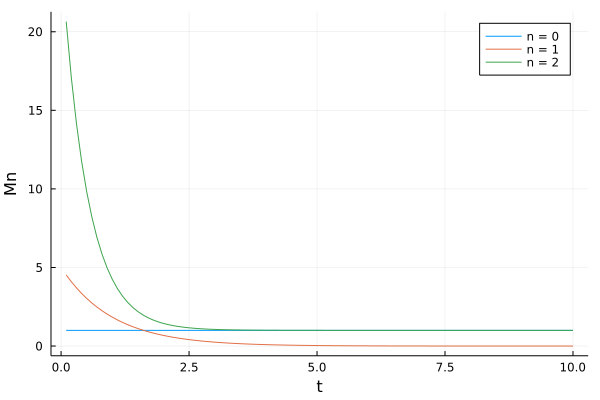

In [10]:
# Finally, let's look at the speed convergence to equilibrium

Tf = 10.0; # final time
K = 100; # number of time points

x = range(-1.5*x0, stop=1.5*x0, length=100);
Δx = x[2]-x[1]; # space increment
# Integrate with a Riemann sum
M0(t) = Δx * sum(p(x, t); dims = 1);
M1(t) = Δx * sum(x .* p(x, t); dims = 1);
M2(t) = Δx * sum(x.^2 .* p(x, t); dims = 1);

T = (Tf/K:Tf/K:Tf)';
plot(T[1,:], [M0(T)[1,:], M1(T)[1,:], M2(T)[1,:]],
    xlabel="t",
    ylabel="Mn",
    label = ["n = 0" "n = 1" "n = 2"]
)
    

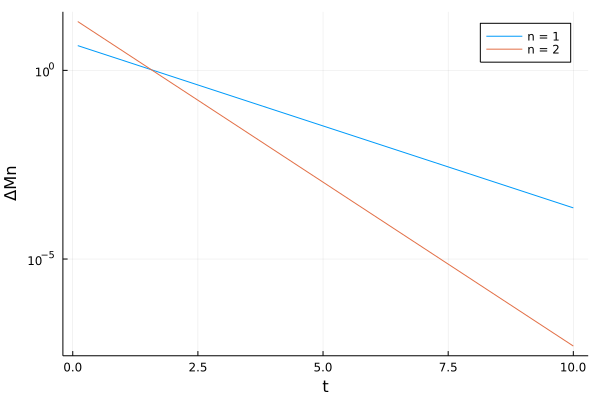

In [11]:
# compare with the stationary density ps:

M0s = Δx * sum(p_s(x); dims = 1);
M1s = Δx * sum(x .* p_s(x); dims = 1);
M2s = Δx * sum(x.^2 .* p_s(x); dims = 1);

plot(T[1,:], [M1(T)[1,:] .- M1s, M2(T)[1,:] .- M2s],
    yscale = :log10,
    xlabel="t",
    ylabel="ΔMn",
    label = ["n = 1" "n = 2"]
)

# Sampling from the stationary density
Suppose we want to sample from the stationary density ps(x). Since OU is an ergodic process, we can either do time-averages or ensemble averages.

For the ensemble average, here I use a long time evolution of the system (easy for the OU process). But in general we would use algorithm targetted at sampling the stationary measure in an efficient way: the Metropolis-Hastings algorithm. 

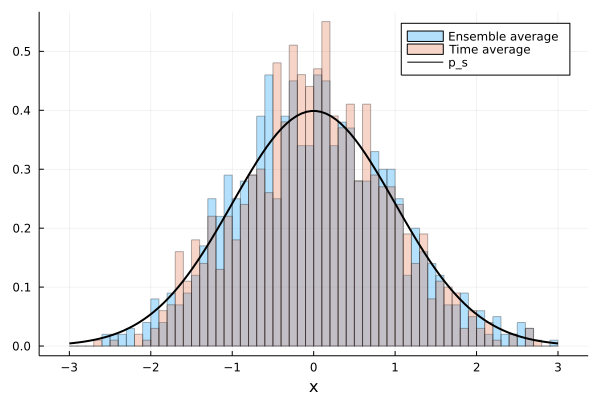

In [12]:
α = 1; # drift
D = 1; # diffusion
x0 = 0.0; # initial condition

mu(t) = x0 * exp.(-α*t); 
var(t) = D/α .* (1 .- exp.(-2 * α * t));

# ensemble average
N = 1000; # number of independent samples
Tf = 100; # take a "long" time
xi = randn(rng, N);
X_ens = mu(Tf) .+ sqrt(var(Tf))*xi;
histogram(X_ens,
        bins = -3:0.1:3,
        normalize=true,
        label="Ensemble average",
        xlabel="x",
        alpha = 0.3
)

# time average
K = N; # number of time steps
Δt = 0.1; 
X_time = zeros(K+1); # vector to store the trajectory
xi = randn(rng,K); # normally distributed increments
X_time[1] = x0; # initial condition
var_Δt = var(Δt); # variance
    for i = 2:K+1
        X_time[i] = exp(-α*Δt) * X_time[i-1] + sqrt(var_Δt)*xi[i-1];
    end

histogram!(X_time,
    bins = -3:0.1:3,
    normalize=true,
    label="Time average",
    xlabel="x",
    alpha = 0.3
)

x = range(-3, stop=3, length=100);
p_s(x) = sqrt(α/(2*pi*D)) * exp.(-α * x.^2/(2*D)); # stationary measure for the OU process
plot!(x, p_s(x), 
    label="p_s",
    linewidth=2,
    linecolor=:black
)

